# Dataset de imagens naturais

In [1]:
# Célula para baixar os dados. Execute apenas uma vez!
from torchvision.datasets.utils import download_and_extract_archive

def download(root):

    url_images = 'https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz'
    url_targets = 'https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz'

    download_and_extract_archive(url_images, root, remove_finished=False)
    download_and_extract_archive(url_targets, root, remove_finished=False)

#download('../data/oxford_pets')

### Criação da classe Dataset

O dataset está organizado da seguinte forma:
* images/ - Diretório com as imagens
* annotations/
    * list.txt - Descrição das imagens, cada linha possui o formato "nome_imagem id_classe id_especie id_raça":
        * id_classe: valor no intervalo [1,37]
        * id_especie: valor 1 (gato) ou 2 (cachorro)
        * id_raça: valor [1,25] para gatos e [1,12] para cachorros
    * trainval.txt - Split sugerido para treinamento e validação. Vamos ignorar
    * test.txt - Split sugerido para teste. Vamos ignorar
    * trimaps/ - Diretório com rótulos para segmentação. Vamos ignorar
    * xmls/ - Diretório com bounding boxes indicando a localização da cabeças dos animais. Vamos ignorar

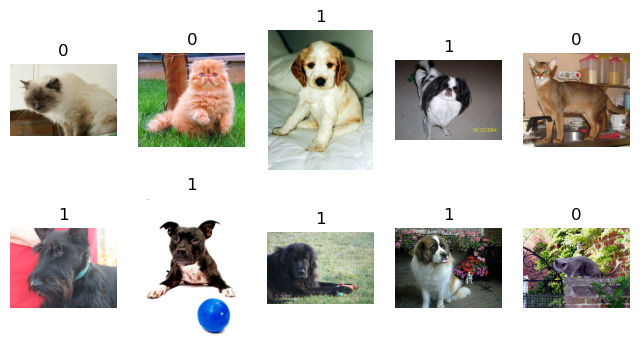

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transf

class OxfordIIITPet(Dataset):

    def __init__(self, root, transforms=None):

        root = Path(root)
        images_folder = root / "images"
        anns_file = root / "annotations/list.txt"

        images = []
        labels = []
        for line in open(anns_file).read().splitlines():
            if line[0]!="#":   # Remove comentários do arquivo
                name, class_id, species_id, breed_id = line.strip().split()
                images.append(images_folder/f'{name}.jpg')
                # -1 para começar em 0
                labels.append(int(species_id)-1)

        self.classes = ['Cat', 'Dog']
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, idx, apply_transform=True):

        # .convert("RGB") para garantir que as imagens são coloridas
        image = Image.open(self.images[idx]).convert("RGB")
        target = self.labels[idx]

        if self.transforms and apply_transform:
            image, target = self.transforms(image, target)

        return image, target
    
    def __len__(self):
        return len(self.images)

def plot_examples(data):

    fig, axs = plt.subplots(2, 5, figsize=(8,4))
    axs = axs.reshape(-1)
    for (img, text), ax in zip(data, axs):
        ax.imshow(img)
        ax.set_title(text)
        ax.set_axis_off()

ds = OxfordIIITPet('../data/oxford_pets')

data = [ds[idx] for idx in torch.randint(0, len(ds), (10,))]
plot_examples(data)

É importante sempre calcularmos para um dataset:

1. A média e desvio padrão das intensidads das imagens em todo o dataset. Esses valores serão utilizados para normalizar as imagens
2. O número de imagens em cada classe, para verificar possíveis desbalanços entre as classes
3. Estatísticas sobre os tamanhos das imagens. Por exemplo, o dataset possui alguma imagem muito grande?

In [3]:
%%time
import numpy as np

def get_statistics(ds):

    n = len(ds)
    mean = np.zeros(3)
    std = np.zeros(3)
    classes = np.array([0,0])
    shapes = np.array([np.inf, -1])  # Armazena o menor e maior tamanho
    for img, target in ds:
        img_np = np.array(img)
        mean += np.mean(img_np, axis=(0,1))
        std += np.std(img_np, axis=(0,1))
        classes[target] += 1

        # Cálculo do menor e maior tamanho de imagens
        shapes[0] = min([shapes[0], img_np.shape[0], img_np.shape[1]])
        shapes[1] = max([shapes[1], img_np.shape[0], img_np.shape[1]])
    mean /= n
    std /= n

    return mean, std, classes, shapes

# Essa função demora para executar
print(get_statistics(ds))

(array([122.74826669, 114.59060423, 100.92046647]), array([59.15813574, 58.44060243, 58.96353786]), array([2371, 4978]), array([ 103., 3264.]))
CPU times: total: 1min 24s
Wall time: 4min 2s


* Vemos que a classe gato possui 2371 imagens enquanto que a cachorro possui 4978
* O menor tamanho de imagem é 103 e o maior 3264. Uma diferença bem grande!

No caso das classes, podemos ponderar os dados de forma inversa à frequência das classes:

In [3]:
n1 = 2371  # Nro de imagens na classe gato
n2 = 4978  # Nro de imagens na classe cachorro
weights = (n2/(n1+n2), n1/(n1+n2))
print(weights)

(0.6773710708939992, 0.32262892910600083)


### Definição das transformações e do dataloader

In [4]:
transforms = transf.Compose([
    transf.PILToTensor(),   # Também converte a posição dos canais da imagem HWC -> CHW
    transf.ToDtype(torch.float32),
    transf.Normalize(mean=(122.7, 114.6, 100.9), std=(59.2, 58.4, 59.0))
])

ds = OxfordIIITPet('../data/oxford_pets', transforms=transforms)
ds[0][0]

tensor([[[-1.4476, -1.4814, -1.4645,  ...,  2.0997,  2.1334,  2.1334],
         [-1.4814, -1.4814, -1.4476,  ...,  2.0828,  2.1166,  2.1334],
         [-1.4814, -1.4645, -1.4139,  ...,  2.0997,  2.1503,  2.1503],
         ...,
         [-1.9882, -2.0051, -2.0051,  ..., -0.8395, -1.0084, -0.9071],
         [-2.0051, -2.0220, -2.0220,  ..., -1.0422, -1.1436, -0.9916],
         [-1.5997, -1.5997, -1.6166,  ..., -1.0760, -0.9747, -0.7889]],

        [[-1.6199, -1.6541, -1.6370,  ...,  2.2842,  2.2842,  2.2842],
         [-1.6541, -1.6541, -1.6199,  ...,  2.2671,  2.2671,  2.2842],
         [-1.6541, -1.6370, -1.5856,  ...,  2.2500,  2.3014,  2.3014],
         ...,
         [-1.8596, -1.8767, -1.8767,  ...,  0.0582, -0.1986, -0.0788],
         [-1.9110, -1.9281, -1.9281,  ..., -0.2671, -0.2842, -0.1130],
         [-1.5000, -1.5000, -1.5000,  ..., -0.3527, -0.1473,  0.0411]],

        [[-1.5068, -1.5407, -1.5237,  ...,  2.5780,  2.5780,  2.5780],
         [-1.5407, -1.5407, -1.5068,  ...,  2

In [5]:
# Criação do dataloader
# !Esse código dará erro!
dl = DataLoader(ds, batch_size=8)
try:
    next(iter(dl))
except RuntimeError as re:
    print(re)

stack expects each tensor to be equal size, but got [3, 500, 394] at entry 0 and [3, 313, 450] at entry 1


O código acima dá erro! Isso porque o dataloader precisa criar um batch de imagens no qual todas as imagens possuem o mesmo tamanho. Mas as nossas imagens possuem tamanhos diferentes. Para resolver esse problema, o dataloader possui um argumento opcional `collate_fn`, que é uma função responsável por transformar as imagens em um batch:

In [6]:
def collate_fn(batch):
    '''Recebe uma lista de tuplas (image,target) e retorna um tensor com
    todas as imagens e outro com todos os rótulos.'''
    
    images, targets = list(zip(*batch))
    # Redimensiona cada imagem para (224, 224)
    images = [transf.functional.resize(img, (224, 224)) for img in images]
    # Concatena os valores em um tensor
    batched_imgs = torch.stack(images)
    batched_targets = torch.tensor(targets)

    return batched_imgs, batched_targets

dl = DataLoader(ds, batch_size=8, collate_fn=collate_fn, shuffle=True)
next(iter(dl))[0].shape

torch.Size([8, 3, 224, 224])

Mas iremos usar a transformação RandomResizedCrop nos nossos dados, o que possibilita fixar o tamanho de todas as imagens.

In [7]:
transforms = transf.Compose([
    transf.PILToTensor(),   # Recomendado por questão de eficiência
    transf.RandomResizedCrop(size=(224,224), scale=(0.5,1.), ratio=(0.7,1.3)),
    transf.RandomHorizontalFlip(),
    transf.ToDtype(torch.float32),
    transf.Normalize(mean=(122.7, 114.6, 100.9), std=(59.2, 58.4, 59.0))
])

ds = OxfordIIITPet('../data/oxford_pets', transforms=transforms)
dl = DataLoader(ds, batch_size=8)

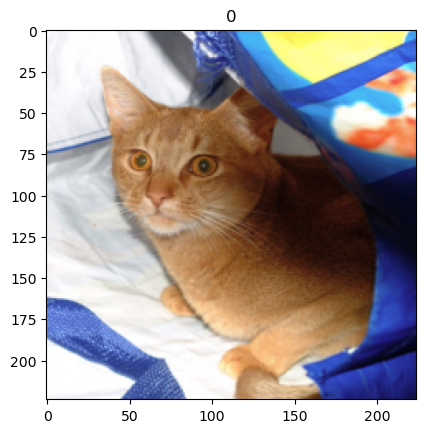

In [8]:
def unormalize(img):
    '''Função que reverte as transformações realizadas para possibilitar
    a visualização das imagens.'''
    img = img.permute(1, 2, 0)
    mean = torch.tensor([122.7, 114.6, 100.9])
    std = torch.tensor([59.2, 58.4, 59.0])
    img = img*std + mean
    img = img.to(torch.uint8)

    return img

imgs, targets = next(iter(dl))
plt.imshow(unormalize(imgs[0]))
plt.title(targets[0].item());

### Processamento dos dados de forma paralela

O parâmetro `num_workers` da classe DataLoader define o número de processos a serem usados para ler os dados do disco e aplicar as transformações nas imagens. Cada processo lê um batch diferente do disco. Por exemplo, supondo `num_workers=3`, o laço `for imgs, targets in dl:` fará as operações:

* ||||| Processo 1 carrega o batch 1
* .||||| Processo 2 carrega o batch 2
* ..||||| Processo 3 carrega o batch 3
* .......||||| Processo 1 carrega o batch 4
* ........||||| Processo 2 carrega o batch 5
* .........||||| Processo 3 carrega o batch 6

In [10]:
dl = DataLoader(ds, batch_size=64, num_workers=5)